# Assignment 5: Graph Neural Networks with `PyG`
> PLEASE enter Your FULL NAME<br>
> Created: DATE <br>


## Introduction
In this assignment we build a **graph neural network** (GNN) mathematically identitical to the one in `06.GNN` but  using **PyTorch Geometric** (`PyG`). See `06.GNN/code/tutorial_GNN.ipynb` for details.
The goal is to classify events as **signal** or **background**, where each event is modeled as a list of data pertaining to particles: the transverse momentum of a particle, $p_T$ and its direction $(\eta, \phi)$. The quantity $\eta = -\log\tan (\theta/2)$ is the pseudo-rapidity, $\theta$ the polar angle, and $\phi$ the azimuthal angle.


## Tips

  * Use __esc r__ to disable a cell
  * Use __esc y__ to reactivate it
  * Use __esc m__ to go to markdown mode. **Markdown** is the typesetting language used in jupyter notebooks.
  * In a markdown cell, double tap the mouse or glide pad (on your laptop) to go to edit mode.
  * Shift + return to execute a cell (including markdown cells).
  * If the equations don't typeset, try double tapping the cell again, and re-execute it.

## Installation of `mlinphysics`

### Local installation
  ```bash
      git clone https://github.com/hbprosper/mlinphysics
      cd mlinphysics
      pip install -e .
  ```
### Google Colab installation `mlinphysics`
  1. Assign Colab working folder to string `COLAB_FOLDER` in notebook.
  2. Execute cell below.

In [ ]:
COLAB_FOLDER = 'ML' # change as needed
GITHUB_USER  = 'hbprosper'
GITHUB_REPO  = 'mlinphysics'
GITHUB_FOLDERS = ['mlinphysics']
#------------------------------------------------------
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
    print('\nGoogle Drive mounted\n')
    IN_COLAB = True
except:
    print('\nRunning locally\n')
    IN_COLAB = False

if IN_COLAB:
    MYDRIVE     = '/content/gdrive/MyDrive'
    GITHUB_BASE = 'https://raw.githubusercontent.com'
    MAIN        = 'refs/heads/main'
    GITHUB_PATH = f'{MYDRIVE}/{COLAB_FOLDER}'
    #------------------------------------------------------
    %cd {GITHUB_PATH}
    %rm -f {GITHUB_PATH}/clone2colab.ipynb
    !wget -q {GITHUB_BASE}/{GITHUB_USER}/{GITHUB_REPO}/{MAIN}/clone2colab.ipynb
    %run {GITHUB_PATH}/clone2colab.ipynb

    %pip install torch_geometric

Mounted at /content/gdrive

Google Drive mounted

/content/gdrive/MyDrive/ML


# Assignment

## PART 1

### 1. Install PyTorch Geometric:
     
```bash
    conda install pytorch_geometric
```
     
### 2. Download the latest version of `mlinphysics` and install using the **pip** command

```bash
    git clone https://github.com/hbprosper/mlinphysics
    cd mlinphysics
    pip install -e .
```
      
### 3. Download data file `events.h5`

```bash
    wget http://www.hep.fsu.edu/~harry/mlinphysics/datasets/events.h5
```

**Note**: Do not work in `mlinphysics`! Work in a different folder.


**PART 2** is below.


In [3]:
import os, sys
import numpy as np
import importlib
import shutil
import matplotlib as mp
import matplotlib.pyplot as plt
from tqdm import tqdm

# PyTorch
import torch
import torch.nn as nn

# PyG
from torch_geometric.nn import global_mean_pool
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import scatter, softmax, subgraph

# ML in physics module
import mlinphysics.nn as mlp
import mlinphysics.utils.data as dat
import mlinphysics.utils.monitor as mon
import mlinphysics.utils.tutorials as tut

# update fonts
if not IN_COLAB:

    plt.rcParams.update({
      "text.usetex": shutil.which('latex') is not None,
      "font.family": "sans-serif",
      "font.sans-serif": "Helvetica",
      "font.size": 14
  })

## Computational device

In [4]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'\n\tAvailable device: {str(DEVICE):4s}\n')


	Available device: cuda



## Load Events
The dataset comprises 36,000 events divided equally between signal and background that have been randomly shuffled. The targets can be accessed using the key 'targets' and an event is accessed by specifying the event number  'N', with the first event being '0'.

In [6]:
events, targets = tut.load_events('events.h5')

targets.shape, events[0].shape, events[1].shape

100%|██████████| 36000/36000 [00:14<00:00, 2429.52it/s]



	sample size:               36000
	min[multiplicity]:            29
	avg[multiplicity] +/-std:    148.3 +/-50.1    
	max[multiplicity]:           529
	avg[pT]:                      23.4 GeV


((36000,), (107, 3), (128, 3))

## Plot Events

The particle's transverse momentum is proportional to the area of the markers.

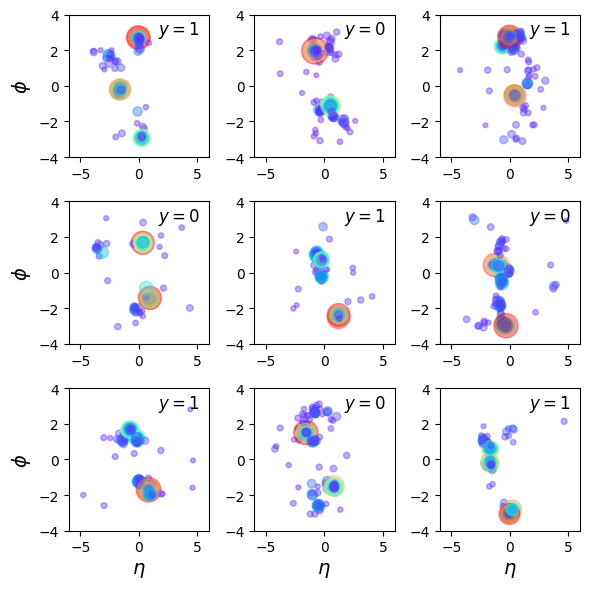

In [7]:
importlib.reload(tut)

tut.plot_events(events, targets)

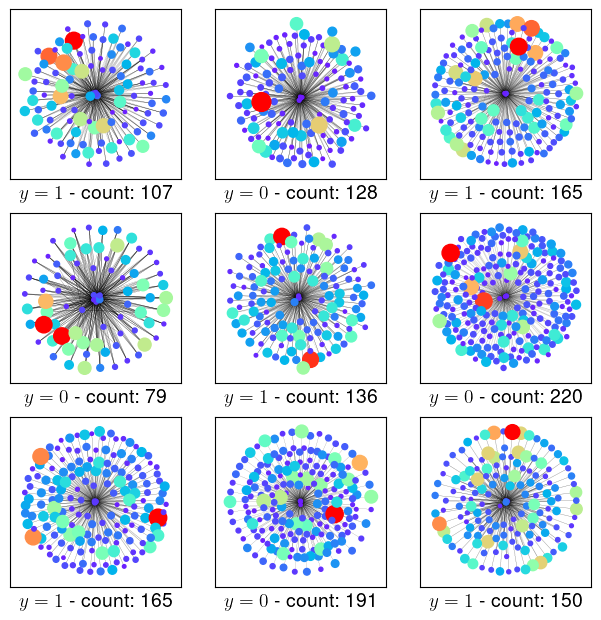

In [ ]:
N = 9
x = [torch.tensor(events[i].reshape(1, -1, 3)) for i in range(N)]
y = torch.tensor(targets[:N].astype(int)).view(-1, 1)
tut.plot_graphs(zip(x, y), scale=8)

## Configuration

In [8]:
# name of model
# -----------------------------------------
name = 'sigbkg'

# choose whether to create or load a configuration file
load_existing_config = False

if load_existing_config:
    config = mlp.Config(f'{name}.yaml')
else:
    # create new configuration
    config = mlp.Config(name, dirname='GAE')

    # training configuration
    # -----------------------------------------
    config('train_size',   32_000) # training sample size
    config('test_size',     3_900) # test sample size
    config('val_size',        100) # validation sample size
    config('batch_size',        1) # number of graphs / batch
    config('monitor_step',    100) # monitor training every n (=10) iterations
    config('delete', True)         # delete losses file before training, if True
    config('frac', 0.01)           # save model if average loss decreases by
                                   # more than fraction "frac"

    # optimizer / scheduler configuration
    # -----------------------------------------
    # a step comprises a given number of iterations
    config('n_steps', 4)                # number of training steps
    config('n_iters_per_step', config('train_size'))
    config('base_lr', 2.e-3)            # initial learning rate
    config('gamma', 0.5)                # learning rate scale factor
    # learning rate scale factor
    print(f'\nSave configuration to file {config.cfg_filename}\n')

    config.save()

# add number of iterations
config('n_iterations',
       config('n_iters_per_step') * \
       config('n_steps'))

print(config)


Save configuration to file runs/GAE/sigbkg_config.yaml

name: sigbkg
file:
  losses: runs/GAE/sigbkg_losses.csv
  params: runs/GAE/sigbkg_params.pth
  init_params: runs/GAE/sigbkg_init_params.pth
  plots: runs/GAE/sigbkg_plots.png
train_size: 32000
test_size: 3900
val_size: 100
batch_size: 1
monitor_step: 100
delete: true
frac: 0.01
n_steps: 4
n_iters_per_step: 32000
base_lr: 0.002
gamma: 0.5
n_iterations: 128000



## Prepare datasets and dataloaders
  1. Scale data.
  2. Build an inhomogeneous `numpy` array of events. Why?
  3. Split data into training, testing, and validation sets.

### Scale data

Scale events and convert data to 32-bit floats.

In [9]:
#                  pT, eta,   phi
scale = np.array([[50,   5, np.pi]], dtype=np.float32)

sevents = [event.astype(np.float32) / scale for event in events]
targets = targets.astype(np.float32)

sevents[0].dtype, targets[0].dtype

(dtype('float32'), dtype('float32'))

## Datasets

Create a dataset of graphs, one for every event. Every particle in an event is modeled as a node (or vertex) of a graph.

In [10]:
train_size = config('train_size')
val_size   = config('val_size')
test_size  = config('test_size')

# training dataset (this defines the empirical risk to be minimized)
print('training data')
train_data = tut.GraphDataset(sevents,
                          start=0,
                          end=train_size,
                          targets=targets)

# a random subset of the training data to check for overtraining
# by comparing with the empirical risk from the validation set
print('training data for validation')
train_data_val = tut.GraphDataset(sevents,
                              start=0,
                              end=train_size,
                              targets=targets,
                              random_sample_size=val_size)

# validation dataset (for monitoring training)
print('validation data')
val_data = tut.GraphDataset(sevents,
                        start=train_size,
                        end=train_size + val_size,
                        targets=targets)

# test dataset
print('test data')
test_data= tut.GraphDataset(sevents,
                        start=train_size + val_size,
                        end=train_size + val_size + test_size,
                        targets=targets)

train_data[0]

training data


100%|██████████| 32000/32000 [00:22<00:00, 1414.58it/s]


Dataset
  shape of x: 32000
  shape of y: 32000

training data for validation


100%|██████████| 100/100 [00:00<00:00, 861.33it/s]


Dataset
  shape of x: 100
  shape of y: 100

validation data


100%|██████████| 100/100 [00:00<00:00, 1134.68it/s]


Dataset
  shape of x: 100
  shape of y: 100

test data


100%|██████████| 3900/3900 [00:04<00:00, 790.19it/s]

Dataset
  shape of x: 3900
  shape of y: 3900



Data(x=[107, 3], edge_index=[2, 11449], y=[1])

## DataLoaders

In [11]:
print('train data loader')
train_loader = DataLoader(train_data,
                             batch_size=config('batch_size'),
                             shuffle=True)

print('train data loader for validation')
train_loader_val = DataLoader(train_data_val,
                                 batch_size=len(train_data_val))

print('validation data loader')
val_loader = DataLoader(val_data,
                           batch_size=len(val_data))

print('test data loader')
test_loader = DataLoader(test_data,
                            batch_size=50)

train data loader
train data loader for validation
validation data loader
test data loader


In [12]:
batch = next(iter(train_loader))
batch.x.shape, batch.edge_index.shape, batch.y.shape, batch.batch.shape

(torch.Size([150, 3]),
 torch.Size([2, 22500]),
 torch.Size([1]),
 torch.Size([150]))

## Build Model

### Conceptual framework
Consider a graph $G = (V, E)$ with $n$   nodes (i.e., vertices) $V = \{V_0,\cdots, V_{n-1}\}$ and $K$ edges $E = \{E_0, \cdots, E_{K-1} \}$. An **edge** can be modeled as the triplet $(i, j, e_{(i,j)})$, where $i$ and $j$ are indices that identify the two connecting nodes $V_i$ and $V_j$, respectively, and $e_{(i,j)}$ are the attributes associated with the edge identified by the **edge index** $(i, j)$. If a **message** $M$ is passed from vertex $V_j$ to $V_i$,
$$V_j \rightarrow M \rightarrow V_i,$$
the vertex $V_j$ is called a **source node**, while the receiving vertex $V_i$ is called a **target node**. A message is a function of the attributes of a source node and attributes of the associated edge; in the simplest case  a message is a vector of scaled source attributes where the scaling is the edge attribute or **weight**.

Given a target node, all messages from the source nodes to which the target is connected are entered into an **aggregation** function which  creates a new vector of attributes that replaces the existing attributes of the target node.

### Adjacency matrix $A$
An event with $n$ particles can be modeled as a graph with $n$ nodes.  Inspired by IceCube, we model the attributes associated with edges of the graph as an $n \times n$ adjacency matrix $A$ where the matrix elements are given by
\begin{align}
    d_{ij} & = \exp(-\alpha \| x_i - x_j \|^2), \\
    e_{(i,j)} & = \texttt{softmax}(d_{ij}, \, \texttt{dim}=1) ,
\end{align}
where $x_i = (\eta_i, \phi_i)$ and $\alpha$ is a free parameter. An adjacency matrix implicitly encodes the edge index $(i, j)$ between nodes $i$ and $j$ and explicitly encodes the edge attributes $e_{(i,j)}$. In `PyG`, the edge index is defined with a tensor of shape $[2, K]$ called `edge_index` such that the target and source nodes, `trg_nodes` and `src_nodes`, respectively, are given by
```python
    trg_nodes, src_nodes = edge_index
```
The use of edge indices, basically the "address" of an element in the adjacency matrix, makes it possible for `PyG` to handle sparse adjacency matrices efficiently.

But in this notebook we create graphs that are
**fully-connected**. This is not the ideal use case for `PyG`. Indeed, `PyG` runs an order of magnitude slower than the previous version  of the tutorial (`06.GNN/code/tutorial_GNN.ipynb`) which makes direct use of the adjacency matrix. However, the classification example is a pedagogically simple way to introduce PyTorch Geometric.

# Assignment
## PART 2    
The goal is to test your understanding of matrix multiplication using the `scatter` function.
   
   1. Write your own version of `scatter` (without using an AI assistant) and verify that you get the same answer as the `PyG` version.
   2. Run the notebook to completion using the `PyG` `scatter` function.

###  1. Get one graph from `test_data`

In [23]:
nodes = test_data[0].x                       # nodes = X

num_nodes = len(nodes)

edge_index = test_data[0].edge_index

target_nodes, source_nodes = edge_index

nodes.shape, edge_index.shape, num_nodes**2

(torch.Size([180, 3]), torch.Size([2, 32400]), 32400)

### 2. Compute edge attributes

This is equivalent to computing a flattened version of the adjacency matrix $A$, that is, the matrix elements $e_{(i,j)}$.

In [14]:
edge_attrs = tut.edge_weights(nodes, edge_index, 20).unsqueeze(-1)

edge_attrs.shape

torch.Size([32400, 1])

### 3. Compute messages

This is equivalent to computing a flattened version of the matrix $X^\prime = A X$.

In [15]:
messages = edge_attrs * nodes[source_nodes]

messages.shape

torch.Size([32400, 3])

### 4. Scatter

This sums the messages per target node so that the result is the matrix $X^\prime$.

In [16]:
Xprime = scatter(messages, target_nodes, reduce='sum')

Xprime.shape, Xprime[:16]

(torch.Size([180, 3]),
 tensor([[ 0.3237,  0.0974, -0.0399],
         [ 0.3242,  0.1014, -0.0330],
         [ 0.3245,  0.0987, -0.0407],
         [ 0.3210,  0.0947, -0.0368],
         [ 0.3231,  0.0997, -0.0340],
         [ 0.3228,  0.0979, -0.0378],
         [ 0.3475,  0.1254,  0.0216],
         [ 0.3416,  0.1255,  0.0075],
         [ 0.3892,  0.1266,  0.1087],
         [ 0.3297,  0.1356, -0.0938],
         [ 0.3199,  0.1353, -0.0836],
         [ 0.4173,  0.1289,  0.1619],
         [ 0.4116,  0.1290,  0.1527],
         [ 0.3571,  0.1308,  0.0434],
         [ 0.4303,  0.1287,  0.1784],
         [ 0.3499,  0.1412, -0.1362]], device='cuda:0'))

### 5. `myscatter(messages, trg_nodes)`

Code your own version of scatter.

In [1]:
def myscatter(messages, trg_nodes):

    # YOUR CODE
    step = np.sqrt(len(messages))
    xprime = np.zeros(16)

    return xprime

X_prime = myscatter(messages, target_nodes)

X_prime.shape, X_prime[:16]

NameError: name 'messages' is not defined

### Graph Convolution: $\texttt{GNNConv}$
We implement a graph convolutional layer that differs from the one implemented by IceCube.
As in most GNNs, the nodes are concatenated into a matrix, $V$, of shape $(n, d)$, where $n$ is the number of nodes and $d$ is the dimensionality of the input feature space. The graph convolution operation is defined by the following computations
\begin{align}
    A & = f(V),&\quad\text{node adjacency  }\\
    X & = \sigma(V W_1^T + B_1), &\quad\text{node embedding}\\
    X^\prime & = A X, &\quad\text{node attention  }\\
    Z & = X^\prime W_2^T + B_2,
\end{align}
that is, a linear function that maps the vertices of $V$ to a vector in an embedding space of dimension $h$, thereby yielding a matrix of shape $(n, h)$. Then a nonlinear operation, $\sigma(*)$, is applied (usually, elementwise) to every element of the embedded vectors. The adjacency matrix $A$, which we choose to be a function of the input nodes $V$, defines the *neighborhood* structure of the graph (see details above). The closer neighbors are weighted more than those further away. The learnable parameter $\alpha$ determines the scale of the nearest neighbor domains.    

Next we compute $X^\prime = AX$, which implements a simple **attention** mechanism in which each target node "pays attention" to its nearest neighbors. Finally, another linear operation is performed which embeds the vector in $X^\prime$ in another vector space.

In [ ]:
class GNNConv(nn.Module):
    def __init__(self, in_features, embed_dim, out_features,
                 activation=nn.ReLU()):

        super().__init__()

        self.activation = activation

        # we embed the "n" input vertices in a larger vector
        # space of dimension h = embed_dim
        self.embed_dim = embed_dim
        self.embed  = nn.Linear(in_features, embed_dim)
        self.linear = nn.Linear(embed_dim, out_features)

    def forward(self, V, edge_index, edge_attrs):
        # V[n=num_nodes, d=in_features]  - nodes in the current batch
        # edge_index[2, K=num_edges] - edges in the current batch
        # edge_attrs[K] - associated edge attributes

        trg_nodes, src_nodes = edge_index

        # 1: Embed input nodes in vector space of h = embed_dim dimensions
        X = self.activation(self.embed(V)) # X[num_nodes, embed_dim]

        # 2: Create messages associated with edges. Note: These edges
        #    may form self-consistent sub-graphs. (In the present context,
        #    a message from a source node to a target node is a scaled
        #    vector, weight * vector, in the embedding space but with
        #    the weight computed in the input space using the formula
        #    for e_(i,j) given above.)
        #
        #    Note: X has shape [num_nodes, embed_dim], while X[src_nodes]
        #    has shape [num_edges, embed_dim] and weights has shape
        #    [num_edges, ]. Therefore, we need to change the shape of
        #    weights to [num_edges, 1] so that every feature of a given
        #    source node is scaled by the weight associated with the
        #    associated edge.
        #
        #    Creating the messages and calling scatter is mathematically
        #    equivalent to computing X^prime = AX.

        messages = edge_attrs.unsqueeze(-1) * X[src_nodes]

        # 3. Send messages from all source nodes to the target nodes
        #    to which they are linked. Then aggregate these messages
        #    by summing them vectorially per target nodes. These
        #    operations, which are equivalent to computing A*X, can
        #    be done with the scatter function.
        #
        # calling sequence:
        #    torch_scatter.scatter(messages, trg_nodes, dim=0, reduce='sum')
        #
        #    dim=0 specifies that the messages to a given target node
        #    should be summed vertically, that is, along the dim=0 axis.

        X = scatter(messages, trg_nodes, dim=0, reduce='sum')

        # 4. Final transformation
        Z = self.linear(X)

        return Z

### Build GNN

In [ ]:
class GNN(mlp.Model):

    def __init__(self, in_features, embed_dim, out_features,
                 activation=nn.ReLU(),
                 dropout=0.5,
                 alpha=1.0):

        # initialize base class
        super().__init__()

        self.activation = activation

        # Note use of nn.Parameter to tell PyTorch that the parameter
        # alpha is to be fitted.
        self.alpha  = nn.Parameter(alpha * torch.rand(1))

        self.conv1  = GNNConv(in_features, embed_dim, embed_dim)
        self.conv2  = GNNConv(embed_dim, embed_dim, embed_dim)
        self.dropout= nn.Dropout(dropout)
        self.output = nn.Sequential(nn.Linear(embed_dim, out_features),
                                    nn.Sigmoid())

    def forward(self, batch):
        V = batch.x
        # V[num_nodes, in_features]  : all nodes

        edge_index = batch.edge_index
        # edge_index[2, num_edges]       : [subset of] edges

        # Compute edge weights, which is equivalent to
        # computing the matrix A.
        edge_attrs = tut.edge_weights(V, edge_index, self.alpha)

        X = self.conv1(V, edge_index, edge_attrs)
        X = self.activation(X)
        X = self.dropout(X)

        X = self.conv2(X, edge_index, edge_attrs)
        X = self.activation(X)
        X = self.dropout(X)

        # average features over nodes
        X = global_mean_pool(X, batch.batch)

        y_pred = self.output(X)

        return y_pred

## Instantiate training objects
  1. `model`
  2. `optimizer`
  1. `scheduler`
  1. `objective`

In [ ]:
importlib.reload(mlp)

model = GNN(in_features=3, embed_dim=40, out_features=1).to(DEVICE)
print(model)
print('number of parameters:', mlp.number_of_parameters(model))
print()

optimizer = torch.optim.Adam(model.parameters(), lr=config('base_lr'))

scheduler = mlp.get_steplr_scheduler(optimizer, config)

# make a specialized objective from mlp.Objective
class GNNObjective(mlp.Objective):
    def __init__(self, model, avgloss):
        super().__init__(model, avgloss)

    def forward(self, batch):
        y_pred = self.model(batch).reshape(batch.y.shape)
        return self.avgloss(y_pred, batch.y)

objective = GNNObjective(model, nn.BCELoss())

GNN(
  (activation): ReLU()
  (conv1): GNNConv(
    (activation): ReLU()
    (embed): Linear(in_features=3, out_features=40, bias=True)
    (linear): Linear(in_features=40, out_features=40, bias=True)
  )
  (conv2): GNNConv(
    (activation): ReLU()
    (embed): Linear(in_features=40, out_features=40, bias=True)
    (linear): Linear(in_features=40, out_features=40, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (output): Sequential(
    (0): Linear(in_features=40, out_features=1, bias=True)
    (1): Sigmoid()
  )
)
number of parameters: 5122

number of milestones:          3

Step | Milestone | LR
-----------------------------
   0 |         0 | 2.0e-03   
-----------------------------
   1 |     32000 | 1.0e-03   
   2 |     64000 | 5.0e-04   
   3 |     96000 | 2.5e-04   

number of iterations:         128000



## Define trainer

In [ ]:
importlib.reload(mlp)

def train(objective, optimizer, scheduler,
          train_loader, train_small_loader, val_loader,
          config):

    # get configuration info
    lossfile   = config('file/losses')
    paramsfile = config('file/params')
    monstep    = config('monitor_step')
    delete     = config('delete')
    frac       = config('frac')
    n_epochs   = config('n_steps')
    n_iters    = config('n_iterations')

    # instantiate object that saves average losses to
    # a csv file for realtime monitoring
    losswriter = mon.LossWriter(n_iters,
                                lossfile,
                                step=monstep,
                                delete=delete,
                                frac=frac,
                                model=objective.model,
                                paramsfile=paramsfile)

    # instantiate learning rate step scheduler
    lrscheduler = mlp.LRStepScheduler(optimizer, scheduler)

    # -----------------------------
    # training loop
    # -----------------------------

    for epoch in range(n_epochs):

        for jj, batch in enumerate(train_loader):

            ii = jj + epoch * len(train_loader)

            # set mode to training so that training-specific
            # operations such as dropout, etc., are enabled.
            objective.train()

            # clear all gradients
            optimizer.zero_grad()

            # compute empirical risk
            R = objective(batch)

            # compute gradients
            R.backward()

            # take one step downhill in the empirical risk landscape
            optimizer.step()

            # check whether to update learning rate
            lrscheduler.step()

            # I'm alive printout
            if (ii % monstep == 0) or (ii == n_iters-1):

                # compute average losses on training and validation data
                with torch.no_grad():

                    # set mode to evaluation so that training-specific
                    # operations such as dropout, etc., are disabled.
                    objective.eval()

                    b = next(iter(train_loader_val))
                    t_loss = float(objective(b).detach().cpu())

                    b = next(iter(val_loader))
                    v_loss = float(objective(b).detach().cpu())

                # return current learning rate
                lr = lrscheduler.lr()

                # update loss file
                losswriter(ii, t_loss, v_loss, lr, epoch)

## Train Model


		learning rate:  2.000e-03
     31900| 24.92%|00:08:04/00:24:19|  65.8 it/s|         0|4.862e-01|4.435e-01|
		learning rate:  1.000e-03
     63900| 49.92%|00:16:55/00:16:58|  62.9 it/s|         1|4.469e-01|3.863e-01|
		learning rate:  5.000e-04
     95900| 74.92%|00:26:10/00:08:45|  61.1 it/s|         2|4.589e-01|3.906e-01|
		learning rate:  2.500e-04
    127999|100.00%|00:35:21/00:00:00|  60.3 it/s|         3|4.500e-01|3.824e-01|


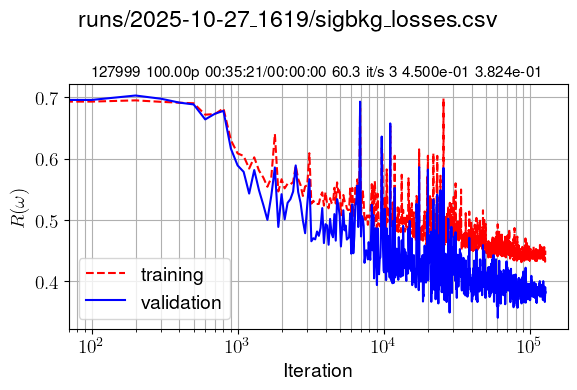

In [ ]:
train(objective, optimizer, scheduler,
      train_loader, train_loader_val, val_loader,
      config)

monitor = mon.Monitor(config('file/losses'))
monitor.plot()

## Plot Results

  1. Confusion matrix for signals defined by $y \geq 1/2$.
  2. Classifier distribution $\hat{y} = D(G)$.
  3. ROC curve

In [ ]:
importlib.reload(tut)

params_filename = config('file/params')

model.load('runs/2025-10-27_1619/sigbkg_params.pth')

y_hat = []
label = []
for ii, batch in enumerate(tqdm(test_loader)):
    label.append( batch.y.detach().cpu().numpy().flatten() )
    y_hat.append( model(batch).detach().cpu().numpy().flatten() )

y_hat = np.array(y_hat).flatten()
test_targets = np.array(label).flatten()

y_hat.shape, test_targets.shape

100%|███████████████████████████████████████████| 78/78 [00:12<00:00,  6.28it/s]


((3900,), (3900,))

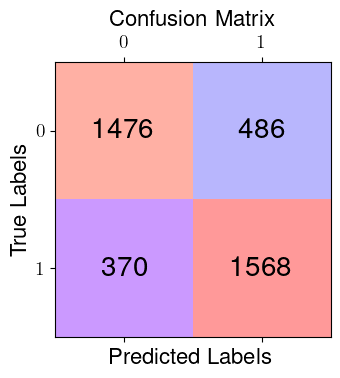

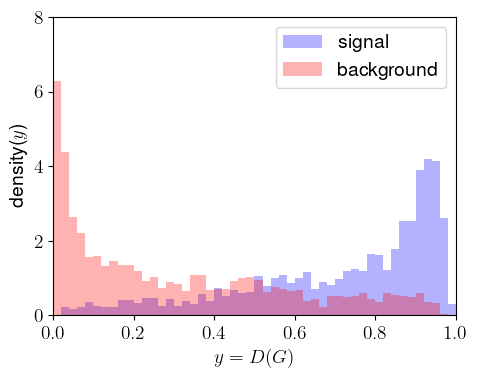

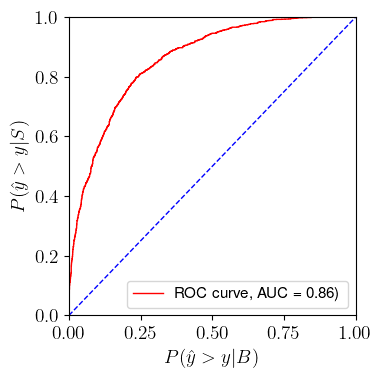

In [ ]:
test_preds = (y_hat > 0.5).astype(int)

tut.plot_confusion_matrix(test_targets, test_preds)
tut.histogram_classifier_outputs(test_targets, y_hat)
tut.plot_roc(test_targets, y_hat)